In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import os
import matplotlib.pyplot as plt

## Carregar Dataset:

Esta base de dados (ml-20m) contém avaliações de filmes entre 0 a 5 estrelas e tags descrevendo o tipo de conteúdo presente no filme. Esta base contém 20000263 votos e 465564 tag aplicadas entre 27278 filmes.

In [2]:
movies_df = next(pd.read_csv('ml-20m/movies.csv', sep=',', header=0, engine='python', chunksize= 50000))
ratings_df = next(pd.read_csv('ml-20m/ratings.csv', sep=',', header=0, engine='python', chunksize= 50000))

movies_df.columns = ['MovieID', 'Title', 'Genres']
ratings_df.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']

In [3]:
movies_df.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


## Preparar base de dados:

- Vamos adicionar uma coluna em **movies_df** informando o seu index na lista de filme.
- Fazer um join entre a matriz de avaliações criando uma tripa do tipo **(filme, usuário e nota)**.
- Remover as colunas restantes.
- Para cada usuário, iremos criar um vetor armazenando a nota do usuário para cada filme e o valor 0 para os filmes não avaliados.

In [5]:
movies_df['List Index'] = movies_df.index
merged_df = movies_df.merge(ratings_df, on='MovieID')
merged_df = merged_df.drop('Timestamp', axis=1).drop('Title', axis=1).drop('Genres', axis=1)
merged_df.head()

,MovieID,List Index,UserID,Rating
0,1,0,3,4.0
1,1,0,6,5.0
2,1,0,8,4.0
3,1,0,10,4.0
4,1,0,11,4.5


In [6]:
user_Group = merged_df.groupby('UserID')

In [7]:
amountOfUsedUsers = 1000
trX = []

In [8]:
for userID, curUser in user_Group:
    temp = [0]*len(movies_df)
    
    for num, movie in curUser.iterrows():
        temp[int(movie['List Index'])] = movie['Rating']/5.0
    
    trX.append(temp)
    if amountOfUsedUsers == 0:
        break
    amountOfUsedUsers -= 1

## Criar modelo:

Utilizaremos a lib do **tensorflow** para desenvolver um modelo chamado RBM (Restricted Bolzmann Machine) para aplicar a ideia de filtro colaborativo.

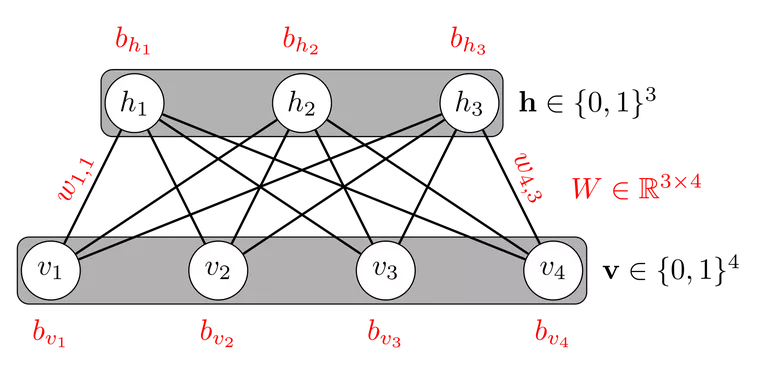

### Input:

- vb: Bias da camada visível.
- hb: Bias da camada escondida.
- W: pesos das conexões entre as unidades escondídas e as visíveis.
- v0: Input do modelo que consiste num vetor com as avaliações de cada filme.

In [9]:
visibleUnits = len(movies_df)
hiddenUnits = 50
vb = tf.placeholder(tf.float32, [visibleUnits])
hb = tf.placeholder(tf.float32, [hiddenUnits])
W = tf.placeholder(tf.float32, [visibleUnits, hiddenUnits])
v0 = tf.placeholder("float", [None, visibleUnits])

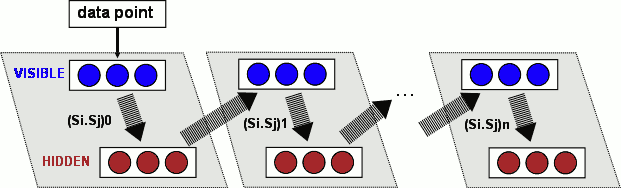

## Propagação para frente (forward propagation)

Inicializaremos **v0** com o vetor de avaliações de usuários obtido anteriormente **(trX)**.

Neste tipo de modelo, a propagação é um pouco diferente. Por ser um modelo estocástico, utilizamos parte dos dados para treinar, ou seja, o usuário não avaliou todos os filmes o que nos dá um vetor input incompleto. Então, utilizaremos um método chamado **Gibbs sampling** para reconstruir o input com todas as avaliações e metrificar a reconstrução para treinar o modelo.

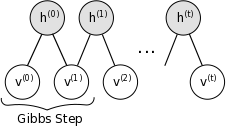

### Propagação de $v^{(0)}$ para $h^{(0)}$:

$
    h^{(0)}=Sigm( \sigma(v^{(0)}*W + hb) )
$

Utilizaremos a função de ativação **Relu**. A propagação nos dará um vetor de 0's e 1's onde camada escondida é responsável por captar as características presentes no filme, ou seja, cada dimensão do vetor **h0** representa uma característica e caso o filme tenha esta característica será marcado pelo valor 1 caso contrário 0.

In [10]:
# v0 -> h0
_h0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0))))

### Reconstrução do input $v^{(1)}$ a partir de $h^{(0)}$:

$
    v^{(1)} = Sigm(\sigma(h^{(0)}*W^{t} + vb))
$

Durante o treinamento **W** aprenderá as relações entre cada item(filme) e cada feature da camada escondida. Então ao fazer a propagação no sentido inverso, teremos valores maiores nos filmes que tem relação com as features ativadas em $h^{(0)}$.

In [11]:
# h0 -> h1
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb)
v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))

### Propagação de $v^{(1)}$ para $h^{(1)}$ :

Com os novos itens ativos no processo de reconstrução, iremos recriar o vetor de características para analisar se houve mudança nas características ativadas.

In [12]:
# v1 -> h1
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)

## Atualização dos parâmetros:

$
\Delta W = v^{(0)}*(h^{(0)})^{t} - v^{(1)}*(h^{(1)})^{t}
$

$
\Delta vb = v^{(0)} - v^{(1)}
$

$
\Delta hb = h^{(0)} - h^{(1)}
$




$
W = W - \alpha*\Delta W
$

$
vb = vb - \alpha*\Delta vb
$

$
hb = hb - \alpha*\Delta hb
$

Obs: percebe-se que no código abaixo, é multiplicado um valor além de alpha no gradiente. Isso é feito para manter as grandezas equivalentes visto que utilizamos apenas os viés para  atualizar os pesos. 

In [13]:
alpha = 1.0

# Obter os gradientes
w_pos_grad = tf.matmul(tf.transpose(v0), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)

# Contrastive Divergence para maximizar
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(v0)[0])

# Atualizar parâmetros
update_w = W + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(v0 - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)

# Erro médio absoluto
err = v0 - v1
err_sum = tf.reduce_mean(err*err)

## Inicializar treinamento:

Inicializar todos os parâmetros com zero.
- 15 épocas
- 100 usuários por batche

In [14]:
cur_w = np.zeros([visibleUnits, hiddenUnits], np.float32)
cur_vb = np.zeros([visibleUnits], np.float32)
cur_hb = np.zeros([hiddenUnits], np.float32)

prv_w = np.zeros([visibleUnits, hiddenUnits], np.float32)
prv_vb = np.zeros([visibleUnits], np.float32)
prv_hb = np.zeros([hiddenUnits], np.float32)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

0.22693384
0.14468648
0.1034659
0.080657065
0.06687881
0.05631097
0.048767664
0.0419634
0.036465622
0.031330314
0.026133599
0.022396175
0.020313382
0.018126583
0.015984038
0.014347036
0.0130234705
0.012619622
0.0118868565
0.011254537


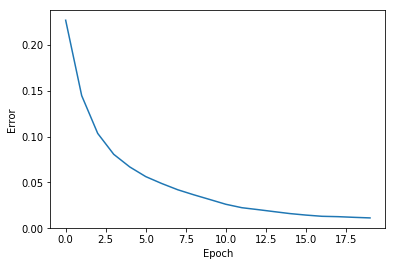

In [15]:
epochs = 20
batchsize = 100
errors = []
for i in range(epochs):
    for start, end in zip(range(0, len(trX), batchsize), range(batchsize, len(trX), batchsize)):
        batch = trX[start:end]
        cur_w = sess.run(update_w, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_hb = sess.run(update_hb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
    errors.append(sess.run(err_sum, feed_dict={v0: trX, W: cur_w, vb: cur_vb, hb: cur_hb}))
    print(errors[-1])
plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()